# Simple RAG for GitHub issues using Hugging Face Zephyr and LangChain

2026-Feb-26

Tutorial: [http://localhost:8888/notebooks/huggingface-rag-zephyr-langchain.ipynb](https://huggingface.co/learn/cookbook/en/rag_zephyr_langchain)

This is just a copy of the tutorial, I fixed the things that needed to be fixed, like imports and stuff but everything and added some comments everything else is just a copy, credits to the author.

## How to run

Create and activate the virtual environment before running the notebook:
```sh
python -m venv .venv # Create if it doesn't exist
source .venv/Scripts/activate
pip install notebook ipykernel iprogress langchain langchain-community langchain-text-splitters torch transformers accelerate bitsandbytes transformers sentence-transformers

# Make note is cpu instead of gpu
pip install faiss-cpu

# pip install faiss-gpu  
```
Start the notebook:
```sh
cd huggingface
jupyter notebook
```


Authored by: Maria Khalusova

This notebook demonstrates how you can quickly build a RAG (Retrieval Augmented Generation) for a project’s GitHub issues using HuggingFaceH4/zephyr-7b-beta model, and LangChain.

## What is RAG?

RAG is a popular approach to address the issue of a powerful LLM not being aware of specific content due to said content not being in its training data, or hallucinating even when it has seen it before. Such specific content may be proprietary, sensitive, or, as in this example, recent and updated often.

If your data is static and doesn’t change regularly, you may consider fine-tuning a large model. In many cases, however, fine-tuning can be costly, and, when done repeatedly (e.g. to address data drift), leads to “model shift”. This is when the model’s behavior changes in ways that are not desirable.

**RAG (Retrieval Augmented Generation)** does not require model fine-tuning. Instead, RAG works by providing an LLM with additional context that is retrieved from relevant data so that it can generate a better-informed response.

Here’s a quick illustration:
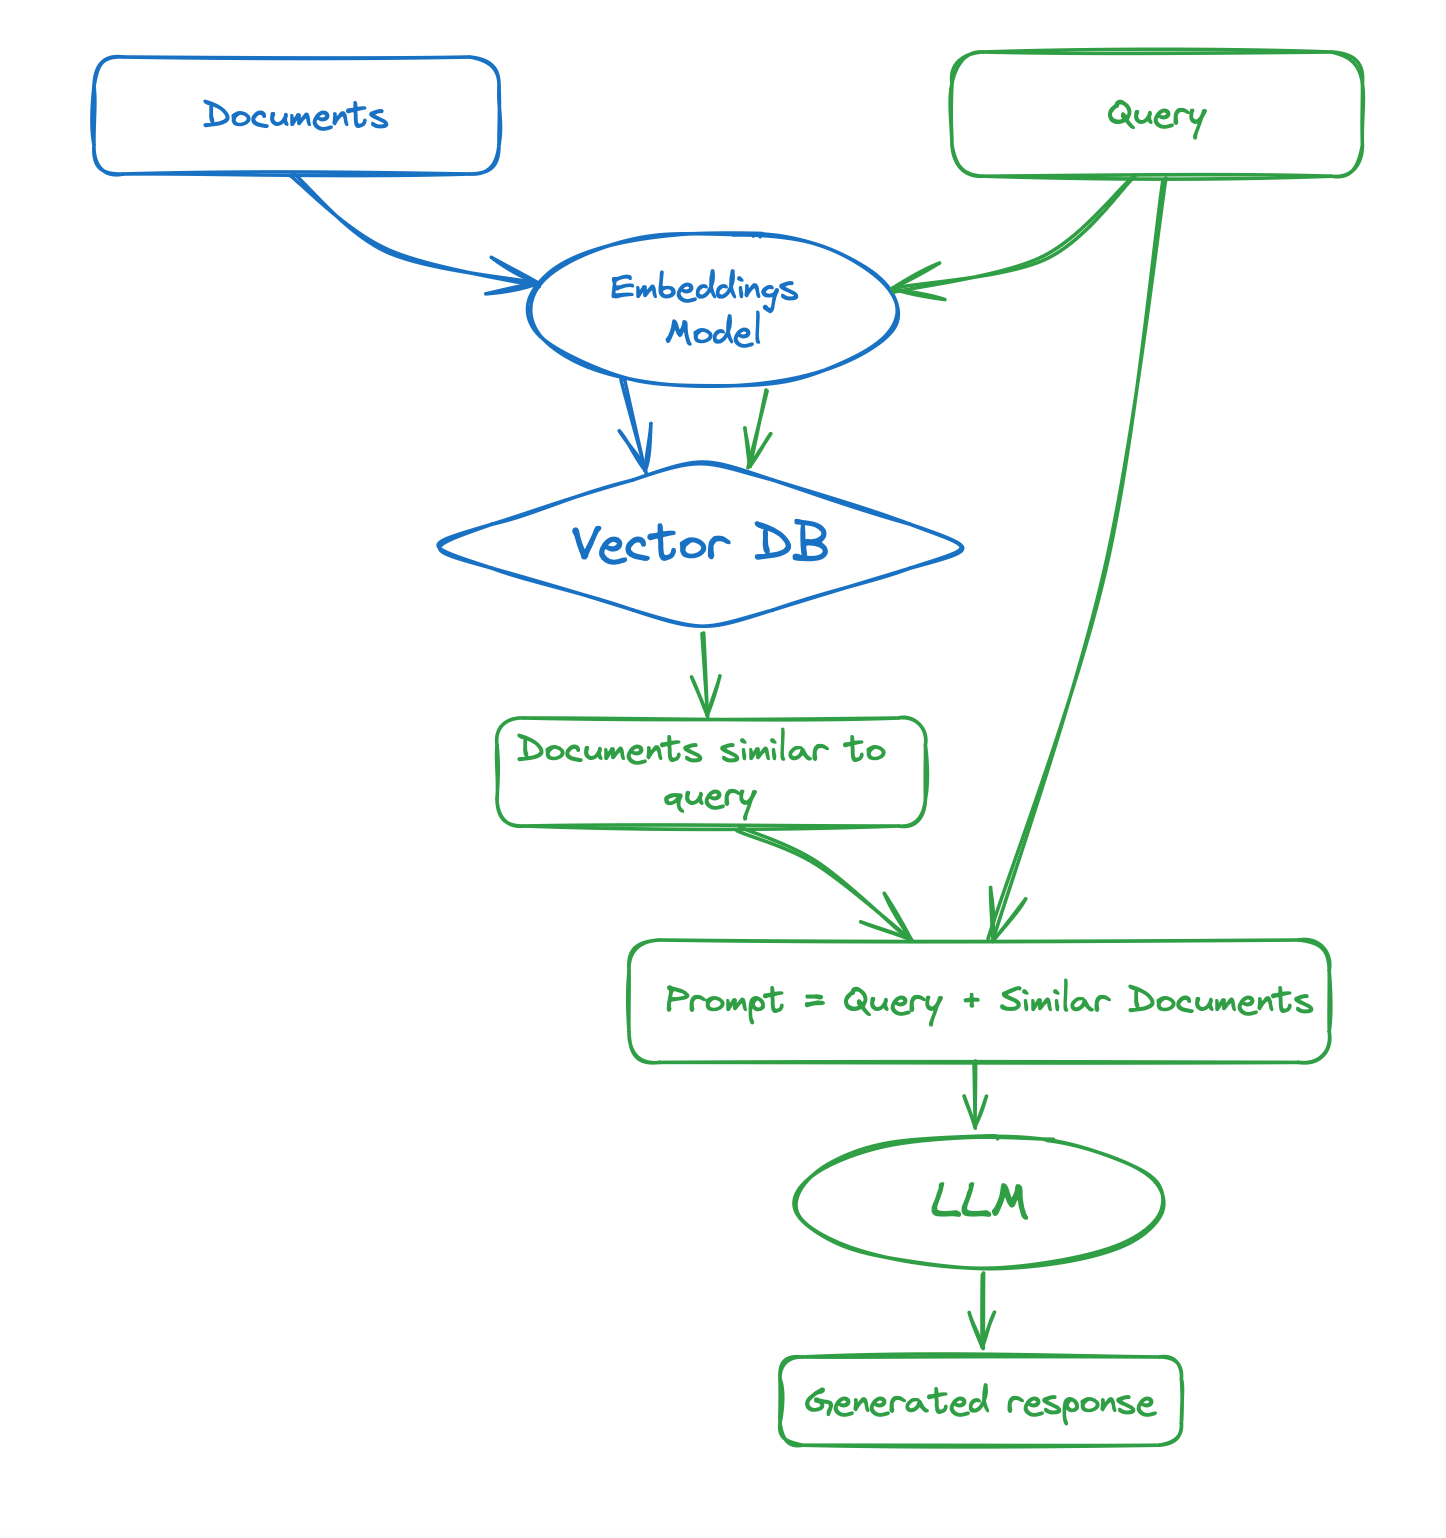

* The external data is converted into embedding vectors with a separate embeddings model, and the vectors are kept in a database. Embeddings models are typically small, so updating the embedding vectors on a regular basis is faster, cheaper, and easier than fine-tuning a model.

* At the same time, the fact that fine-tuning is not required gives you the freedom to swap your LLM for a more powerful one when it becomes available, or switch to a smaller distilled version, should you need faster inference.

Let’s illustrate building a RAG using an open-source LLM, embeddings model, and LangChain.

First, install the required dependencies:

# Imports

Import all the required dependencies

In [10]:
from getpass import getpass
from langchain_community.document_loaders import GitHubIssuesLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# Prepare the data

In this example, we’ll load all of the issues (both open and closed) from PEFT library’s repo.

First, you need to acquire a GitHub personal access token to access the GitHub API.

Next, we’ll load all of the issues in the huggingface/peft repo:

By default, pull requests are considered issues as well, here we chose to exclude them from data with by setting include_prs=False
Setting state = "all" means we will load both open and closed issues.

The content of individual GitHub issues may be longer than what an embedding model can take as input. If we want to embed all of the available content, we need to chunk the documents into appropriately sized pieces.

The most common and straightforward approach to chunking is to define a fixed size of chunks and whether there should be any overlap between them. Keeping some overlap between chunks allows us to preserve some semantic context between the chunks. The recommended splitter for generic text is the RecursiveCharacterTextSplitter, and that’s what we’ll use here.

In [5]:
ACCESS_TOKEN = getpass("YOUR_GITHUB_PERSONAL_TOKEN")
loader = GitHubIssuesLoader(
    repo="huggingface/peft",
    access_token=ACCESS_TOKEN,
    include_prs=False,
    state="all"
)

docs = loader.load()

splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=30)

chunked_docs = splitter.split_documents(docs)

YOUR_GITHUB_PERSONAL_TOKEN ········


## Explore the data

Print a sample of the docs pulled from GitHub, the next cell took some minutes to run

In [12]:
# I got 1352 when I wrote this notebook the first time
print(f'Total number of documents fetched: {len(docs)}') 

docs[0:3] # Assuming we at least have 3 results back 

Total number of documents fetched: 1352


[Document(metadata={'url': 'https://github.com/huggingface/peft/issues/3049', 'title': 'More efficient PISSA initialization for LoRA (faster/cheaper than current SVD)', 'creator': 'Brokttv', 'created_at': '2026-02-18T08:59:30Z', 'comments': 8, 'state': 'closed', 'labels': [], 'assignee': None, 'milestone': None, 'locked': False, 'number': 3049, 'is_pull_request': False}, page_content='### Feature request\n\nI\'d like to propose (and potentially contribute) an improved version of the PiSSA initialization for LoRA adapters. I\'m not sure if the current implementation uses `torch.svd_lowrank` (with optional fast subspace iteration via "pissa_niter_N"), which is already good but can still be quite expensive in time and/or memory for very large layers (e during adapter creation. So, if that the case, I would love to submit a PR.\n\nCC: @BenjaminBossan \n\n### Your contribution\n\nThe algorithm mainly uses Krylov subspace method. I would share the code as soon as you can confirm if this was 

## Create the embeddings + retriever
Now that the docs are all of the appropriate size, we can create a database with their embeddings.

To create document chunk embeddings we’ll use the HuggingFaceEmbeddings and the BAAI/bge-base-en-v1.5 embeddings model. There are many other embeddings models available on the Hub, and you can keep an eye on the best performing ones by checking the Massive Text Embedding Benchmark (MTEB) Leaderboard.

To create the vector database, we’ll use FAISS, a library developed by Facebook AI. This library offers efficient similarity search and clustering of dense vectors, which is what we need here. FAISS is currently one of the most used libraries for NN search in massive datasets.

We’ll access both the embeddings model and FAISS via LangChain API.

In [13]:
# This cell here takes for ever run (Around ~45min), it also prints some weird warning about deprecation
db = FAISS.from_documents(chunked_docs, HuggingFaceEmbeddings(model_name='BAAI/bge-base-en-v1.5'))

Loading weights: 100%|███████████████████████████| 199/199 [00:00<00:00, 549.18it/s, Materializing param=pooler.dense.weight]
BertModel LOAD REPORT from: BAAI/bge-base-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


KeyboardInterrupt: 

We need a way to return(retrieve) the documents given an unstructured query. For that, we’ll use the as_retriever method using the db as a backbone:

* search_type="similarity" means we want to perform similarity search between the query and documents
* search_kwargs={'k': 4} instructs the retriever to return top 4 results.

In [ ]:

retriever = db.as_retriever(
    search_type="similarity",
    search_kwargs={'k': 4}
)

The vector database and retriever are now set up, next we need to set up the next piece of the chain - the model.

## Load quantized model

For this example, we chose HuggingFaceH4/zephyr-7b-beta, a small but powerful model.

With many models being released every week, you may want to substitute this model to the latest and greatest. The best way to keep track of open source LLMs is to check the Open-source LLM leaderboard.

To make inference faster, we will load the quantized version of the model:

In [ ]:
model_name = 'HuggingFaceH4/zephyr-7b-beta'

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(model_name)